# DS-GA 1011 Homework 2
## N-Gram and Neural Language Modeling

In [0]:
import os
import json
import jsonlines
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import numpy as np

## I. N-Gram Language Modeling

#### Utilities

In [0]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

### Additive Smoothing

In [0]:
class NGramAdditive(object):
    def __init__(self, n, delta, vsize):
        self.n = n
        self.delta = delta
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
    
    def estimate(self, sequences):
        for sequence in sequences:
            padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
            for i in range(len(padded_sequence) - self.n+1):
                ngram = tuple(padded_sequence[i:i+self.n])
                prefix, word = ngram[:-1], ngram[-1]
                self.count[prefix][word] += 1
                self.total[prefix] += 1
                
    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(ngram))
        return total_logp

    def ngram_prob(self, ngram):
        prefix = ngram[:-1]
        word = ngram[-1]
        prob = ((self.delta + self.count[prefix][word]) / 
                (self.total[prefix] + self.delta*self.vsize))
        return prob

In [8]:
datasets, vocab = load_wikitext()

delta = 0.0005
for n in [2, 3, 4]:
    lm = NGramAdditive(n=n, delta=delta, vsize=len(vocab)+1)  # +1 is for <eos>
    lm.estimate(datasets['train'])

    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Train Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['train'])))
    print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Valid Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['valid'])))

--2019-09-30 18:16:11--  https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.box.com (nyu.box.com)... 107.152.25.197, 107.152.24.197
Connecting to nyu.box.com (nyu.box.com)|107.152.25.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2019-09-30 18:16:11--  https://nyu.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2019-09-30 18:16:11--  https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.app.box.com (nyu.app.box.com)... 107.152.26.199, 107.152.27.199
Connecting to nyu.app.box.com (nyu.app.box.com)|107.152.26.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Locati

### I.1 Interpolation

In [0]:
class NGramInterpolation(object):
    def __init__(self, n, lamb_list, vsize):
        # lamb_list should be a list containing all lambda values for interpolation
        self.n = n
        self.count = defaultdict(lambda: defaultdict(float))
        self.total = defaultdict(float)
        self.vsize = vsize
        self.word_count = defaultdict(float) # Count of every word
        self.length = 0 # The total length of the dataset
        
        # Check if lambda fulfill our conditions
        if len(lamb_list) != n + 1:
            raise ValueError("Lambda list must have length n + 1")
        elif np.abs(np.sum(lamb_list) - 1) > 0.00001:
            raise ValueError("Sum of lambdas must be 1")
        self.lamb_list = lamb_list

    def estimate(self, sequences):
        for sequence in sequences:
            for w in sequence:
                self.word_count[w] += 1
                self.length += 1
            for current_n in range(2, self.n + 1):
                padded_sequence = ['<bos>']*(current_n-1) + sequence + ['<eos>']
                for i in range(len(padded_sequence) - current_n+1):
                    ngram = tuple(padded_sequence[i:i+current_n])
                    prefix, word = ngram[:-1], ngram[-1]
                    self.count[prefix][word] += 1
                    self.total[prefix] += 1

    def sequence_logp(self, sequence):
        padded_sequence = ['<bos>']*(self.n-1) + sequence + ['<eos>']
        total_logp = 0
        for i in range(len(padded_sequence) - self.n+1):
            ngram = tuple(padded_sequence[i:i+self.n])
            total_logp += np.log2(self.ngram_prob(lamb_list[-1], ngram, self.n))
        return total_logp
    
    def ngram_prob(self, lamb, ngram, order):
        """
        lamb: a single value from the lambda list
        order: means which index of lambda we are talking about, max and initial
            order should be n
        """
        
        if order > n:
            raise ValueError("Order can't exceed n")
        elif order == 0:
            return lamb * (1 / self.vsize) # Since p_0 = 1 / |vocab|
        elif order >= 1:
            prefix = ngram[:-1]
            word = ngram[-1]
            if prefix: # Check if prefix is empty
                if self.total[prefix] == 0:
                    prob = 0
                else:
                    prob = self.count[prefix][word] / self.total[prefix]
            else: # If prefix is empty, we are in lambda_1
                prob = self.word_count[word] / self.length
            
            return lamb * prob + self.ngram_prob(self.lamb_list[order], 
                                                 ngram[1:], order - 1)
            

In [48]:
for n in [2, 3, 4]:
    if n == 2:
        lamb_list = [0.2, 0.4, 0.4]
    elif n == 3:
        lamb_list = [0.2, 0.2, 0.3, 0.3]
    else:
        lamb_list = [0.1, 0.1, 0.2, 0.2, 0.4]
    interp = NGramInterpolation(n=n, lamb_list = lamb_list, vsize=len(vocab)+1)  # +1 is for <eos>
    interp.estimate(datasets['train'])

    print(f"Interpolation model, n = {n}, lambda = {lamb_list}, Train Perplexity = {perplexity(interp, datasets['train'])}")
    print(f"Interpolation model, n = {n}, lambda = {lamb_list}, Validation Perplexity = {perplexity(interp, datasets['valid'])}")

Interpolation model, n = 2, lambda = [0.2, 0.4, 0.4], Train Perplexity = 149.14058601187182
Interpolation model, n = 2, lambda = [0.2, 0.4, 0.4], Validation Perplexity = 330.56932143293216
Interpolation model, n = 3, lambda = [0.2, 0.2, 0.3, 0.3], Train Perplexity = 19.476557684727467
Interpolation model, n = 3, lambda = [0.2, 0.2, 0.3, 0.3], Validation Perplexity = 283.3942638303449
Interpolation model, n = 4, lambda = [0.1, 0.1, 0.2, 0.2, 0.4], Train Perplexity = 3.71422334002876
Interpolation model, n = 4, lambda = [0.1, 0.1, 0.2, 0.2, 0.4], Validation Perplexity = 310.2176484896974


#### Results (showing $\lambda_0,\ldots,\lambda_n$ values):

In [54]:
for n in [4]:
    if n == 2:
        lamb_list = [0.2, 0.4, 0.4]
    elif n == 3:
        lamb_list = [0.2, 0.2, 0.3, 0.3]
    else:
        lamb_list = [0.05, 0.15, 0.2, 0.3, 0.3]
    interp = NGramInterpolation(n=n, lamb_list = lamb_list, vsize=len(vocab)+1)  # +1 is for <eos>
    interp.estimate(datasets['train'])

    print(f"Interpolation model, n = {n}, lambda = {lamb_list}, Train Perplexity = {perplexity(interp, datasets['train'])}")
    print(f"Interpolation model, n = {n}, lambda = {lamb_list}, Validation Perplexity = {perplexity(interp, datasets['valid'])}")

Interpolation model, n = 4, lambda = [0.05, 0.15, 0.2, 0.3, 0.3], Train Perplexity = 4.706373565940121
Interpolation model, n = 4, lambda = [0.05, 0.15, 0.2, 0.3, 0.3], Validation Perplexity = 281.6049590165684


## II. Neural Language Modeling with a Recurrent Neural Network

In [0]:
import torch
import torch.nn as nn

#### Utilities

(Hint: you can adopt the `Dictionary`, dataset loading, and training code from the lab for use here)

### II.1 LSTM and Hyper-Parameters

#### Results (LSTM vs. Baseline)

#### Performance Variation Based on Hyperparameter Values

### II.2 Learned Embeddings

#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [0]:
%pylab inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(20,20))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


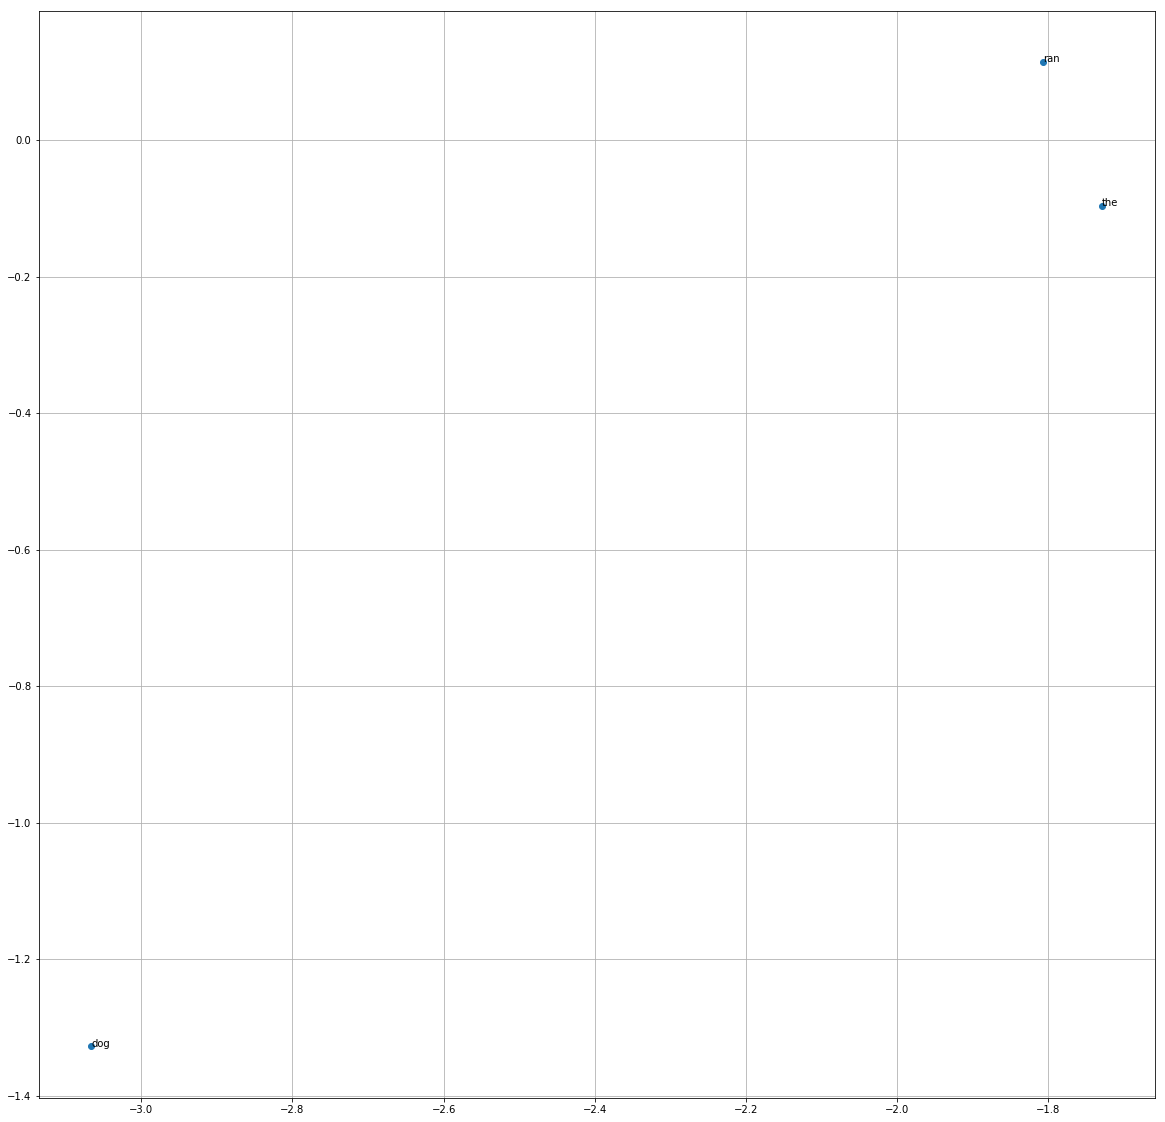

In [0]:
Vsize = 100                                 # e.g. len(dictionary)
d = 32                                      # e.g. model.lookup.weight.size(1) 
fake_weight_matrix = torch.randn(Vsize, d)  # e.g. model.lookup.weight

words = ['the', 'dog', 'ran']
word_ids = [4, 54, 20]                  # e.g. use dictionary.get_id on a list of words

umap_plot(fake_weight_matrix, word_ids, words)

#### II.2.1 Word Similarity

#### II.2.2 Embedding Layer

#### II.2.3 Projection Layer

### II.3 Scoring

#### II.3.2 Highest and Lowest scoring sequences

#### II.3.3 Modified sequences

### II.4 Sampling

#### II.4.3 Number of unique tokens and sequence length 

(1,000 samples vs. 1,000 randomly selected validation-set sequences)

#### II.4.4 Example Samples